# **Federated Learning with (PeerReview-)Flower and FedAvg**

### Installing dependencies

First, we install the necessary packages:

In [ ]:
!pip install git+https://github.com/passerim/peer-reviewed-flower.git

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [1]:
import os; os.chdir("../.."); import prflwr; os.chdir("experiments/fedls")

In [2]:
import os
import random
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from prflwr.simulation import start_simulation
from prflwr.utils import non_iid_partitions
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms

## Setup

Set useful constants, experiments settings and random seed.

In [3]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # admissible values: "CIFAR10" or "CIFAR100"
NUM_ROUNDS = 30
NUM_CLIENTS = 100
LOCAL_EPOCHS = 5
BATCH_SIZE = 50
FRACTION_FIT = 0.1
FRACTION_EVAL = 0  # Model performance will be evaluated in a centralized way
print(f"Training for {NUM_ROUNDS} rounds")

# Device to use for training and evaluation
DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")

Training for 30 rounds
Training on cpu


## Data loading

Let's now load the CIFAR-10 (or CIFAR-100) training and test set, partition them into `NUM_CLIENTS` smaller datasets (each split into training and validation set), and wrap everything in their own `DataLoader`. Test data will be used to evaluate model's performance in a centralized way.

In [5]:
def load_datasets(
    num_clients: int,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS, src="../../data/cifar10")

Files already downloaded and verified
Files already downloaded and verified


## Model training/evaluation

Let's continue with the usual model definition (including `set_parameters` and `get_parameters`), training and test functions:

In [14]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs=1, lr=0.01):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= (batch + 1)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= (batch + 1)
    accuracy = correct / total
    return loss, accuracy

Let's check model's correctness, then print some info about the datasets and splits.

In [15]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))

Model parameters: 45626
Client's trainset size: 450
Client's validation set size: 50
Server's testset size: 10000


## Flower client

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`. Here, we also pass the `cid` to the client and use it log additional details.

### Sending/receiving arbitrary values to/from clients

In some situations, we want to dinamically configure client side training and evaluation from the server-side, for example by setting the learning rate or the local epochs. Flower provides a way to send configuration values from the server to the clients using a dictionary. Clients receive values from the server through the `config` parameter and can read values from this dictionary.

In [16]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        learning_rate = config["learning_rate"]
        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, local_epochs, learning_rate)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net(NUM_CLASSES).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

We can send the config dictionary from the server to the clients providing a function to the strategy that gets called every round of federated learning.

In [17]:
def fit_config(server_round: int):
    # os.system("rm -r /tmp/ray")
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs":  LOCAL_EPOCHS,
        "learning_rate": 0.25 * (0.99 ** (server_round - 1)),
    }
    return config

## Customizing the FedAvg strategy

The strategy encapsulates the federated learning algorithm, in this notebook we will use the standard version of FedAvg. We will also customize the parameters initilization of the global model and the centralized model evaluation.

### Server-side parameter **initialization**

Flower, by default, initializes the global model by asking one random client for the initial parameters, however when more control on the initialization is needed passing `initial_parameters` to the `FedAvg` strategy prevents Flower from asking one of the clients for the initial parameters.

In [18]:
initial_parameters = fl.common.ndarrays_to_parameters(get_parameters(Net(NUM_CLASSES)))

### Server-side parameter **evaluation**

With Flower, we can evaluate the aggregated model on the server-side or on the client-side. Centralized evaluation is conceptually simpler: if there is a server-side dataset that can be used for evaluation purposes, then we can evaluate the newly aggregated model after each round of training without having to send the model to clients.

In [19]:
# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net(NUM_CLASSES).to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

## Running federated learning

Let's run a federated learning experiment with a large number of clients. We have 100 partitions, each holding 450 training and 50 validation examples. We configure the clients to perform 5 local training epochs. The federated learning simulation is started by the function `start_simulation`, in this case we will use the sequential simulation implemented in PeerReview-Flower. The `start_simulation` function accepts a number of arguments:
* `client_fn` is used to create `FlowerClient` instances,
* the number of clients to simulate is specified by `num_clients`,
* the number of rounds `num_rounds` is encapsulated in a `flwr.server.ServerConfig`,
* `strategy` is used to specify the custom strategy we configured above.

In [20]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=FRACTION_FIT,              # Train on 10 clients (each round)
    fraction_evaluate=FRACTION_EVAL,        # Evaluate on 50 clients (each round)
    min_fit_clients=int(NUM_CLIENTS * FRACTION_FIT),
    min_evaluate_clients=int(NUM_CLIENTS * FRACTION_EVAL),
    min_available_clients=NUM_CLIENTS,
    initial_parameters=initial_parameters,  # Pass the initial parameters
    on_fit_config_fn=fit_config,            # Pass the fit_config function
    evaluate_fn=evaluate,                   # Pass the evaluation function
)

history = start_simulation(
    strategy=strategy,
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
)

INFO flower 2023-01-02 13:01:57,923 | app.py:95 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flower 2023-01-02 13:01:58,059 | server.py:86 | Initializing global parameters
INFO flower 2023-01-02 13:01:58,060 | server.py:266 | Using initial parameters provided by strategy
INFO flower 2023-01-02 13:01:58,061 | server.py:88 | Evaluating initial parameters
INFO flower 2023-01-02 13:02:00,795 | server.py:91 | initial parameters (loss, other metrics): 2.30655566573143, {'accuracy': 0.1}
INFO flower 2023-01-02 13:02:00,796 | server.py:101 | FL starting
DEBUG flower 2023-01-02 13:02:00,797 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.30655566573143 / accuracy 0.1
[Client 48, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 47, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 37, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 15, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 33, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 64, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 77, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 41, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'learning_rate': 0.25}
[Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 5, 'lear

DEBUG flower 2023-01-02 13:02:13,705 | server.py:229 | fit_round 1 received 10 results and 0 failures
WARNING flower 2023-01-02 13:02:13,738 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


Epoch 5: train loss 2.230281194051107, accuracy 0.17777777777777778
Epoch 5: train loss 2.2224558459387884, accuracy 0.16666666666666666
Epoch 5: train loss 2.2325150436825223, accuracy 0.14
Epoch 5: train loss 2.235481341679891, accuracy 0.16666666666666666
Epoch 5: train loss 2.2077820830874972, accuracy 0.19777777777777777
Epoch 5: train loss 2.193068186442057, accuracy 0.20222222222222222
Epoch 5: train loss 2.2245153850979276, accuracy 0.1622222222222222
Epoch 5: train loss 2.208337518903944, accuracy 0.18888888888888888


INFO flower 2023-01-02 13:02:16,912 | server.py:116 | fit progress: (1, 2.1898021697998047, {'accuracy': 0.1751}, 16.11516770900016)
INFO flower 2023-01-02 13:02:16,912 | server.py:163 | evaluate_round 1: no clients selected, cancel
DEBUG flower 2023-01-02 13:02:16,913 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.1898021697998047 / accuracy 0.1751
[Client 48, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 75, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 49, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 38, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 13, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 59, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 73, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 97, round 2] fit, config: {'server_round': 2, 'local_epochs': 5, 'learning_rate': 0.2475}
[Client 90, round 2] fit, config: {'server_round': 2, 

DEBUG flower 2023-01-02 13:02:33,642 | server.py:229 | fit_round 2 received 10 results and 0 failures


Epoch 5: train loss 2.0777696238623724, accuracy 0.2111111111111111
Epoch 5: train loss 2.2037636174096003, accuracy 0.19555555555555557
Epoch 5: train loss 2.08044351471795, accuracy 0.21777777777777776
Epoch 5: train loss 2.1314909987979465, accuracy 0.20222222222222222
Epoch 5: train loss 2.1081909603542752, accuracy 0.22
Epoch 5: train loss 2.149714575873481, accuracy 0.1688888888888889
Epoch 5: train loss 2.077318549156189, accuracy 0.21333333333333335
Epoch 5: train loss 2.1232753064897327, accuracy 0.2088888888888889
Epoch 5: train loss 2.1228226158354015, accuracy 0.21777777777777776
Epoch 5: train loss 2.122673087649875, accuracy 0.18


INFO flower 2023-01-02 13:02:37,318 | server.py:116 | fit progress: (2, 2.0629611456394197, {'accuracy': 0.2207}, 36.52160762300082)
INFO flower 2023-01-02 13:02:37,319 | server.py:163 | evaluate_round 2: no clients selected, cancel
DEBUG flower 2023-01-02 13:02:37,319 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.0629611456394197 / accuracy 0.2207
[Client 41, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 31, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 82, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 57, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 56, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 34, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 72, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 73, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 44, round 3] fit, config: {'server_round': 3, 'local_epochs': 5, 'learning_rate': 0.245025}
[Client 88, round 3] fit, config: {

DEBUG flower 2023-01-02 13:02:51,406 | server.py:229 | fit_round 3 received 10 results and 0 failures


Epoch 5: train loss 2.0681487321853638, accuracy 0.19777777777777777
Epoch 5: train loss 2.081366393301222, accuracy 0.21333333333333335
Epoch 5: train loss 2.0606825086805554, accuracy 0.20444444444444446
Epoch 5: train loss 2.0146531661351523, accuracy 0.21555555555555556
Epoch 5: train loss 2.039378219180637, accuracy 0.21777777777777776
Epoch 5: train loss 2.1045691437191434, accuracy 0.23555555555555555
Epoch 5: train loss 2.089146296183268, accuracy 0.21555555555555556
Epoch 5: train loss 2.058923509385851, accuracy 0.2111111111111111
Epoch 5: train loss 2.115175631311205, accuracy 0.16
Epoch 5: train loss 2.0434206459257336, accuracy 0.1711111111111111


INFO flower 2023-01-02 13:02:54,573 | server.py:116 | fit progress: (3, 2.0181534522771836, {'accuracy': 0.2438}, 53.77632574299969)
INFO flower 2023-01-02 13:02:54,573 | server.py:163 | evaluate_round 3: no clients selected, cancel
DEBUG flower 2023-01-02 13:02:54,574 | server.py:215 | fit_round 4: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 2.0181534522771836 / accuracy 0.2438
[Client 58, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 73, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 64, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 35, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 43, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 23, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 15, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 5, 'learning_rate': 0.24257475}
[Client 54, round 4

DEBUG flower 2023-01-02 13:03:10,283 | server.py:229 | fit_round 4 received 10 results and 0 failures


Epoch 5: train loss 2.0715315341949463, accuracy 0.22444444444444445
Epoch 5: train loss 2.12237458758884, accuracy 0.20222222222222222
Epoch 5: train loss 2.004804836379157, accuracy 0.2288888888888889
Epoch 5: train loss 2.014757831891378, accuracy 0.2644444444444444
Epoch 5: train loss 2.023771736356947, accuracy 0.18888888888888888
Epoch 5: train loss 2.0666589736938477, accuracy 0.23333333333333334
Epoch 5: train loss 2.1133388545778065, accuracy 0.21777777777777776
Epoch 5: train loss 2.098215924368964, accuracy 0.2088888888888889
Epoch 5: train loss 2.0473176373375788, accuracy 0.22
Epoch 5: train loss 2.0337676207224527, accuracy 0.25333333333333335


INFO flower 2023-01-02 13:03:13,068 | server.py:116 | fit progress: (4, 1.9932282614707946, {'accuracy': 0.2604}, 72.27153215199905)
INFO flower 2023-01-02 13:03:13,069 | server.py:163 | evaluate_round 4: no clients selected, cancel
DEBUG flower 2023-01-02 13:03:13,069 | server.py:215 | fit_round 5: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.9932282614707946 / accuracy 0.2604
[Client 84, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 63, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 93, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 16, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 68, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 61, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 60, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}
[Client 69, round 5] fit, config: {'server_round': 5, 'local_epochs': 5, 'learning_rate': 0.2401490025}


DEBUG flower 2023-01-02 13:03:27,844 | server.py:229 | fit_round 5 received 10 results and 0 failures


Epoch 5: train loss 1.982599178949992, accuracy 0.26222222222222225
Epoch 5: train loss 2.0563159916136, accuracy 0.2222222222222222
Epoch 5: train loss 1.9809147251976862, accuracy 0.2688888888888889
Epoch 5: train loss 2.0480017529593573, accuracy 0.2644444444444444
Epoch 5: train loss 1.991031249364217, accuracy 0.23333333333333334
Epoch 5: train loss 1.9657673041025798, accuracy 0.2777777777777778
Epoch 5: train loss 2.0305594073401556, accuracy 0.24444444444444444
Epoch 5: train loss 2.07362343205346, accuracy 0.23777777777777778
Epoch 5: train loss 1.956374168395996, accuracy 0.25555555555555554
Epoch 5: train loss 1.9914069440629747, accuracy 0.22444444444444445


INFO flower 2023-01-02 13:03:30,894 | server.py:116 | fit progress: (5, 1.9428342407941819, {'accuracy': 0.2868}, 90.0976676650007)
INFO flower 2023-01-02 13:03:30,895 | server.py:163 | evaluate_round 5: no clients selected, cancel
DEBUG flower 2023-01-02 13:03:30,896 | server.py:215 | fit_round 6: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.9428342407941819 / accuracy 0.2868
[Client 41, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 47, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 76, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 59, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 28, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 64, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 99, round 6] fit, config: {'server_round': 6, 'local_epochs': 5, 'learning_rate': 0.23774751247499998}
[Client 36, round 6] fit, config: {'server_round

DEBUG flower 2023-01-02 13:03:47,104 | server.py:229 | fit_round 6 received 10 results and 0 failures


Epoch 5: train loss 1.984714561038547, accuracy 0.23333333333333334
Epoch 5: train loss 1.933481878704495, accuracy 0.2688888888888889
Epoch 5: train loss 2.061586936314901, accuracy 0.2644444444444444
Epoch 5: train loss 1.890190389421251, accuracy 0.2866666666666667
Epoch 5: train loss 2.041822499699063, accuracy 0.20222222222222222
Epoch 5: train loss 1.9326417181226943, accuracy 0.2733333333333333
Epoch 5: train loss 1.939159870147705, accuracy 0.28444444444444444
Epoch 5: train loss 2.0012551281187267, accuracy 0.23777777777777778
Epoch 5: train loss 2.044666714138455, accuracy 0.22444444444444445
Epoch 5: train loss 2.0294708410898843, accuracy 0.24


INFO flower 2023-01-02 13:03:50,347 | server.py:116 | fit progress: (6, 1.9086399233341218, {'accuracy': 0.3141}, 109.55071388000033)
INFO flower 2023-01-02 13:03:50,348 | server.py:163 | evaluate_round 6: no clients selected, cancel
DEBUG flower 2023-01-02 13:03:50,349 | server.py:215 | fit_round 7: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.9086399233341218 / accuracy 0.3141
[Client 74, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 41, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 93, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 29, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 49, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 88, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 'learning_rate': 0.23537003735025}
[Client 32, round 7] fit, config: {'server_round': 7, 'local_epochs': 5, 

DEBUG flower 2023-01-02 13:04:06,094 | server.py:229 | fit_round 7 received 10 results and 0 failures


Epoch 5: train loss 2.004818916320801, accuracy 0.21555555555555556
Epoch 5: train loss 1.9426931540171306, accuracy 0.2866666666666667
Epoch 5: train loss 1.9788047340181139, accuracy 0.25333333333333335
Epoch 5: train loss 1.9563140869140625, accuracy 0.27555555555555555
Epoch 5: train loss 1.9043625195821126, accuracy 0.32
Epoch 5: train loss 1.8261998626920912, accuracy 0.30444444444444446
Epoch 5: train loss 1.8448880778418646, accuracy 0.29555555555555557
Epoch 5: train loss 1.8901411957210965, accuracy 0.28888888888888886
Epoch 5: train loss 1.9638357162475586, accuracy 0.24888888888888888
Epoch 5: train loss 2.1218121449152627, accuracy 0.26666666666666666


INFO flower 2023-01-02 13:04:08,773 | server.py:116 | fit progress: (7, 1.937952494621277, {'accuracy': 0.2845}, 127.97628000000077)
INFO flower 2023-01-02 13:04:08,774 | server.py:163 | evaluate_round 7: no clients selected, cancel
DEBUG flower 2023-01-02 13:04:08,774 | server.py:215 | fit_round 8: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.937952494621277 / accuracy 0.2845
[Client 21, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 53, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 45, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 54, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 77, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 63, round 8] fit, config: {'server_round': 8, 'local_epochs': 5, 'learning_rate': 0.23301633697674748}
[Client 86, round 8] fit, config: {'server_round':

DEBUG flower 2023-01-02 13:04:23,987 | server.py:229 | fit_round 8 received 10 results and 0 failures


Epoch 5: train loss 1.8569852908452351, accuracy 0.29333333333333333
Epoch 5: train loss 1.8679549164242215, accuracy 0.3244444444444444
Epoch 5: train loss 1.9097132550345526, accuracy 0.27111111111111114
Epoch 5: train loss 1.8092676401138306, accuracy 0.3377777777777778
Epoch 5: train loss 1.854982402589586, accuracy 0.3288888888888889
Epoch 5: train loss 1.875347720252143, accuracy 0.30444444444444446
Epoch 5: train loss 1.8697546852959528, accuracy 0.3111111111111111
Epoch 5: train loss 1.9215518765979342, accuracy 0.3
Epoch 5: train loss 1.8350060648388333, accuracy 0.29777777777777775
Epoch 5: train loss 1.9312836064232721, accuracy 0.26


INFO flower 2023-01-02 13:04:26,934 | server.py:116 | fit progress: (8, 1.7613398510217666, {'accuracy': 0.3668}, 146.13779058599903)
INFO flower 2023-01-02 13:04:26,935 | server.py:163 | evaluate_round 8: no clients selected, cancel
DEBUG flower 2023-01-02 13:04:26,936 | server.py:215 | fit_round 9: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7613398510217666 / accuracy 0.3668
[Client 34, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 67, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 21, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 97, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 94, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 24, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 38, round 9] fit, config: {'server_round': 9, 'local_epochs': 5, 'learning_rate': 0.23068617360698002}
[Client 63, round 9] fit, config: {'server_round

DEBUG flower 2023-01-02 13:04:42,602 | server.py:229 | fit_round 9 received 10 results and 0 failures


Epoch 5: train loss 1.8369522492090862, accuracy 0.28888888888888886
Epoch 5: train loss 1.7675188382466633, accuracy 0.3511111111111111
Epoch 5: train loss 1.8006599479251437, accuracy 0.33555555555555555
Epoch 5: train loss 1.7830366028679743, accuracy 0.31333333333333335
Epoch 5: train loss 1.8737682501475017, accuracy 0.2822222222222222
Epoch 5: train loss 1.8799626959694757, accuracy 0.3088888888888889
Epoch 5: train loss 1.8372332519955106, accuracy 0.3088888888888889
Epoch 5: train loss 1.8328964842690363, accuracy 0.30666666666666664
Epoch 5: train loss 1.868816958533393, accuracy 0.27555555555555555
Epoch 5: train loss 1.859777569770813, accuracy 0.3333333333333333


INFO flower 2023-01-02 13:04:45,333 | server.py:116 | fit progress: (9, 1.7244032686948776, {'accuracy': 0.3858}, 164.53593137700045)
INFO flower 2023-01-02 13:04:45,333 | server.py:163 | evaluate_round 9: no clients selected, cancel
DEBUG flower 2023-01-02 13:04:45,333 | server.py:215 | fit_round 10: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7244032686948776 / accuracy 0.3858
[Client 36, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 28, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 67, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 11, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 13, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 56, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 69, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 78, round 10] fit, config: {'server_round': 10, 'local_epochs': 5, 'learning_rate': 0.2283793118709102}
[Client 71, round 10] fit, config: {'se

DEBUG flower 2023-01-02 13:05:01,253 | server.py:229 | fit_round 10 received 10 results and 0 failures


Epoch 5: train loss 1.7920867337120905, accuracy 0.3288888888888889
Epoch 5: train loss 1.7783124844233196, accuracy 0.3
Epoch 5: train loss 1.8307017352845933, accuracy 0.31333333333333335
Epoch 5: train loss 1.9792773458692763, accuracy 0.3022222222222222
Epoch 5: train loss 1.8775777551862929, accuracy 0.32
Epoch 5: train loss 1.830125583542718, accuracy 0.32
Epoch 5: train loss 1.9410122897889879, accuracy 0.3333333333333333
Epoch 5: train loss 1.7596766551335652, accuracy 0.36
Epoch 5: train loss 1.7241020335091486, accuracy 0.32666666666666666
Epoch 5: train loss 1.8323746124903362, accuracy 0.30444444444444446


INFO flower 2023-01-02 13:05:05,231 | server.py:116 | fit progress: (10, 1.7422066110372543, {'accuracy': 0.3839}, 184.4346613859998)
INFO flower 2023-01-02 13:05:05,232 | server.py:163 | evaluate_round 10: no clients selected, cancel
DEBUG flower 2023-01-02 13:05:05,233 | server.py:215 | fit_round 11: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.7422066110372543 / accuracy 0.3839
[Client 24, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 66, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 81, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 50, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 57, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 52, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 14, round 11] fit, config: {'server_round': 11, 'local_epochs': 5, 'learning_rate': 0.2260955187522011}
[Client 7, round 11] fit, config: {'serv

DEBUG flower 2023-01-02 13:05:21,057 | server.py:229 | fit_round 11 received 10 results and 0 failures


Epoch 5: train loss 1.7812872992621527, accuracy 0.35333333333333333
Epoch 5: train loss 1.9711047278510199, accuracy 0.28444444444444444
Epoch 5: train loss 1.8705029487609863, accuracy 0.33111111111111113
Epoch 5: train loss 1.6601985957887437, accuracy 0.37777777777777777
Epoch 5: train loss 1.8709504869249132, accuracy 0.3288888888888889
Epoch 5: train loss 1.8233567343817816, accuracy 0.32
Epoch 5: train loss 1.7714420557022095, accuracy 0.3488888888888889
Epoch 5: train loss 1.7506601413091023, accuracy 0.36666666666666664
Epoch 5: train loss 1.7464434040917292, accuracy 0.3488888888888889
Epoch 5: train loss 1.8381249772177801, accuracy 0.28888888888888886


INFO flower 2023-01-02 13:05:23,840 | server.py:116 | fit progress: (11, 1.696931614279747, {'accuracy': 0.3896}, 203.04335266899943)
INFO flower 2023-01-02 13:05:23,841 | server.py:163 | evaluate_round 11: no clients selected, cancel
DEBUG flower 2023-01-02 13:05:23,842 | server.py:215 | fit_round 12: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.696931614279747 / accuracy 0.3896
[Client 55, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 97, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 83, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 66, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 45, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 63, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 17, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 19, round 12] fit, config: {'server_round': 12, 'local_epochs': 5, 'learning_rate': 0.2238345635646791}
[Client 24, round 12] fit, config: {'ser

DEBUG flower 2023-01-02 13:05:39,613 | server.py:229 | fit_round 12 received 10 results and 0 failures


Epoch 5: train loss 1.7308188676834106, accuracy 0.3422222222222222
Epoch 5: train loss 1.7093607981999714, accuracy 0.36666666666666664
Epoch 5: train loss 1.744027230474684, accuracy 0.38
Epoch 5: train loss 1.7664960092968411, accuracy 0.33555555555555555
Epoch 5: train loss 1.7427482340070937, accuracy 0.32666666666666666
Epoch 5: train loss 1.812027374903361, accuracy 0.32
Epoch 5: train loss 1.7292601532406278, accuracy 0.3711111111111111
Epoch 5: train loss 1.713108155462477, accuracy 0.3466666666666667
Epoch 5: train loss 1.7066060702006023, accuracy 0.35555555555555557
Epoch 5: train loss 1.720226486523946, accuracy 0.3466666666666667


INFO flower 2023-01-02 13:05:42,161 | server.py:116 | fit progress: (12, 1.6355706119537354, {'accuracy': 0.4121}, 221.3640436980004)
INFO flower 2023-01-02 13:05:42,161 | server.py:163 | evaluate_round 12: no clients selected, cancel
DEBUG flower 2023-01-02 13:05:42,162 | server.py:215 | fit_round 13: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.6355706119537354 / accuracy 0.4121
[Client 30, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 31, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 26, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 9, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 51, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 5, 'learning_rate': 0.2215962179290323}
[Client 52, round 13] fit, config: {'server

DEBUG flower 2023-01-02 13:05:55,991 | server.py:229 | fit_round 13 received 10 results and 0 failures


Epoch 5: train loss 1.6455899344550238, accuracy 0.4022222222222222
Epoch 5: train loss 1.8267641067504883, accuracy 0.37333333333333335
Epoch 5: train loss 1.7225087351269193, accuracy 0.3844444444444444
Epoch 5: train loss 1.6158446073532104, accuracy 0.4022222222222222
Epoch 5: train loss 1.75866695245107, accuracy 0.35777777777777775
Epoch 5: train loss 1.802494313981798, accuracy 0.3377777777777778
Epoch 5: train loss 1.72171065542433, accuracy 0.3933333333333333
Epoch 5: train loss 1.6587480041715834, accuracy 0.36444444444444446
Epoch 5: train loss 1.6734071969985962, accuracy 0.3488888888888889
Epoch 5: train loss 1.6382562981711493, accuracy 0.37555555555555553


INFO flower 2023-01-02 13:05:58,508 | server.py:116 | fit progress: (13, 1.604927464723587, {'accuracy': 0.4217}, 237.7111636890004)
INFO flower 2023-01-02 13:05:58,508 | server.py:163 | evaluate_round 13: no clients selected, cancel
DEBUG flower 2023-01-02 13:05:58,509 | server.py:215 | fit_round 14: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.604927464723587 / accuracy 0.4217
[Client 41, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 70, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 3, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 93, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 55, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 31, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 89, round 14] fit, config: {'server_round': 14, 'local_epochs': 5, 'learning_rate': 0.21938025574974196}
[Client 37, round 14] fit, config:

DEBUG flower 2023-01-02 13:06:12,781 | server.py:229 | fit_round 14 received 10 results and 0 failures


Epoch 5: train loss 1.7681614425447252, accuracy 0.3333333333333333
Epoch 5: train loss 1.6160165866216023, accuracy 0.39555555555555555
Epoch 5: train loss 1.6778192785051134, accuracy 0.3844444444444444
Epoch 5: train loss 1.6594780153698392, accuracy 0.36666666666666664
Epoch 5: train loss 1.7295196188820734, accuracy 0.3622222222222222
Epoch 5: train loss 1.6924526823891535, accuracy 0.36444444444444446
Epoch 5: train loss 1.8004126416312323, accuracy 0.3466666666666667
Epoch 5: train loss 1.7442264159520466, accuracy 0.3622222222222222
Epoch 5: train loss 1.8099117146597967, accuracy 0.31333333333333335
Epoch 5: train loss 1.784102029270596, accuracy 0.32222222222222224


INFO flower 2023-01-02 13:06:16,120 | server.py:116 | fit progress: (14, 1.594452024102211, {'accuracy': 0.4148}, 255.3235854630002)
INFO flower 2023-01-02 13:06:16,121 | server.py:163 | evaluate_round 14: no clients selected, cancel
DEBUG flower 2023-01-02 13:06:16,121 | server.py:215 | fit_round 15: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.594452024102211 / accuracy 0.4148
[Client 38, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 14, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 36, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 85, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 41, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 82, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 27, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 65, round 15] fit, config: {'server_round': 15, 'local_epochs': 5, 'learning_rate': 0.21718645319224456}
[Client 3, round 15] fit, config

DEBUG flower 2023-01-02 13:06:32,439 | server.py:229 | fit_round 15 received 10 results and 0 failures


Epoch 5: train loss 1.6179063717524211, accuracy 0.4066666666666667
Epoch 5: train loss 1.6733371946546767, accuracy 0.3844444444444444
Epoch 5: train loss 1.665958907869127, accuracy 0.3888888888888889
Epoch 5: train loss 1.7041857242584229, accuracy 0.40444444444444444
Epoch 5: train loss 1.6842546727922227, accuracy 0.3688888888888889
Epoch 5: train loss 1.6976583931181166, accuracy 0.3933333333333333
Epoch 5: train loss 1.6321955256991916, accuracy 0.3844444444444444
Epoch 5: train loss 1.6318930917316012, accuracy 0.39555555555555555
Epoch 5: train loss 1.830537690056695, accuracy 0.33111111111111113
Epoch 5: train loss 1.5433382325702243, accuracy 0.4666666666666667


INFO flower 2023-01-02 13:06:35,141 | server.py:116 | fit progress: (15, 1.5789094483852386, {'accuracy': 0.4274}, 274.3444487800007)
INFO flower 2023-01-02 13:06:35,142 | server.py:163 | evaluate_round 15: no clients selected, cancel
DEBUG flower 2023-01-02 13:06:35,142 | server.py:215 | fit_round 16: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5789094483852386 / accuracy 0.4274
[Client 46, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 19, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 59, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 28, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 65, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 84, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 53, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 55, round 16] fit, config: {'server_round': 16, 'local_epochs': 5, 'learning_rate': 0.2150145886603221}
[Client 50, round 16] fit, config: {'se

DEBUG flower 2023-01-02 13:06:51,075 | server.py:229 | fit_round 16 received 10 results and 0 failures


Epoch 5: train loss 1.5849765009350247, accuracy 0.37777777777777777
Epoch 5: train loss 1.6813403500450983, accuracy 0.3688888888888889
Epoch 5: train loss 1.5646418068144057, accuracy 0.38222222222222224
Epoch 5: train loss 1.5698759688271418, accuracy 0.41333333333333333


INFO flower 2023-01-02 13:06:53,963 | server.py:116 | fit progress: (16, 1.5227009838819503, {'accuracy': 0.4461}, 293.1660834409995)
INFO flower 2023-01-02 13:06:53,963 | server.py:163 | evaluate_round 16: no clients selected, cancel
DEBUG flower 2023-01-02 13:06:53,964 | server.py:215 | fit_round 17: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5227009838819503 / accuracy 0.4461
[Client 24, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 49, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 63, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 36, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 17, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 60, round 17] fit, config: {'server_round': 17, 'local_epochs': 5, 'learning_rate': 0.21286444277371888}
[Client 92, round 17] fit, config

DEBUG flower 2023-01-02 13:07:08,539 | server.py:229 | fit_round 17 received 10 results and 0 failures


Epoch 5: train loss 1.7087595992618136, accuracy 0.4022222222222222
Epoch 5: train loss 1.615629063712226, accuracy 0.3933333333333333
Epoch 5: train loss 1.6466545926200018, accuracy 0.3888888888888889
Epoch 5: train loss 1.6628449625439115, accuracy 0.38666666666666666
Epoch 5: train loss 1.6399537722269695, accuracy 0.38
Epoch 5: train loss 1.577792313363817, accuracy 0.4088888888888889
Epoch 5: train loss 1.6167765193515353, accuracy 0.3888888888888889
Epoch 5: train loss 1.542430837949117, accuracy 0.40444444444444444
Epoch 5: train loss 1.722929384973314, accuracy 0.36666666666666664
Epoch 5: train loss 1.652632474899292, accuracy 0.3688888888888889


INFO flower 2023-01-02 13:07:11,274 | server.py:116 | fit progress: (17, 1.5273851621150971, {'accuracy': 0.442}, 310.4774479030002)
INFO flower 2023-01-02 13:07:11,275 | server.py:163 | evaluate_round 17: no clients selected, cancel
DEBUG flower 2023-01-02 13:07:11,275 | server.py:215 | fit_round 18: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.5273851621150971 / accuracy 0.442
[Client 13, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 16, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 15, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 58, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 45, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 70, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 78, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 5, 'learning_rate': 0.2107357983459817}
[Client 56, round 18] fit, config: {'serv

DEBUG flower 2023-01-02 13:07:26,350 | server.py:229 | fit_round 18 received 10 results and 0 failures


Epoch 5: train loss 1.5297268761528864, accuracy 0.41555555555555557
Epoch 5: train loss 1.630689223607381, accuracy 0.4066666666666667
Epoch 5: train loss 1.5446850193871393, accuracy 0.42444444444444446
Epoch 5: train loss 1.6519183582729764, accuracy 0.4022222222222222
Epoch 5: train loss 1.5916836791568332, accuracy 0.3977777777777778
Epoch 5: train loss 1.5737609068552654, accuracy 0.4111111111111111
Epoch 5: train loss 1.592426790131463, accuracy 0.44222222222222224
Epoch 5: train loss 1.5842842260996501, accuracy 0.4222222222222222
Epoch 5: train loss 1.7022870646582708, accuracy 0.4066666666666667
Epoch 5: train loss 1.4800212118360732, accuracy 0.43555555555555553


INFO flower 2023-01-02 13:07:28,995 | server.py:116 | fit progress: (18, 1.4979898434877397, {'accuracy': 0.4534}, 328.19873994800037)
INFO flower 2023-01-02 13:07:28,996 | server.py:163 | evaluate_round 18: no clients selected, cancel
DEBUG flower 2023-01-02 13:07:28,997 | server.py:215 | fit_round 19: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4979898434877397 / accuracy 0.4534
[Client 45, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 46, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 36, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 27, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 49, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 13, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 96, round 19] fit, config: {'server_round': 19, 'local_epochs': 5, 'learning_rate': 0.20862844036252187}
[Client 65, round 19] fit, confi

DEBUG flower 2023-01-02 13:07:43,596 | server.py:229 | fit_round 19 received 10 results and 0 failures


Epoch 5: train loss 1.5960714022318523, accuracy 0.42Epoch 5: train loss 1.6241389248106215, accuracy 0.41333333333333333

Epoch 5: train loss 1.5469098885854085, accuracy 0.43777777777777777
Epoch 5: train loss 1.5403373771243625, accuracy 0.4311111111111111
Epoch 5: train loss 1.5439459085464478, accuracy 0.45111111111111113
Epoch 5: train loss 1.531611031956143, accuracy 0.42
Epoch 5: train loss 1.6177615059746637, accuracy 0.4
Epoch 5: train loss 1.5711089505089655, accuracy 0.42
Epoch 5: train loss 1.5361890527937148, accuracy 0.43333333333333335
Epoch 5: train loss 1.5814222362306383, accuracy 0.4177777777777778


INFO flower 2023-01-02 13:07:46,347 | server.py:116 | fit progress: (19, 1.4835423177480698, {'accuracy': 0.4596}, 345.5502458310002)
INFO flower 2023-01-02 13:07:46,348 | server.py:163 | evaluate_round 19: no clients selected, cancel
DEBUG flower 2023-01-02 13:07:46,348 | server.py:215 | fit_round 20: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4835423177480698 / accuracy 0.4596
[Client 75, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 85, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 94, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 10, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 99, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 41, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 26, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 49, round 20] fit, config: {'server_round': 20, 'local_epochs': 5, 'learning_rate': 0.20654215595889666}
[Client 23, round 20] fit, conf

DEBUG flower 2023-01-02 13:08:01,187 | server.py:229 | fit_round 20 received 10 results and 0 failures


Epoch 5: train loss 1.5722376373079088, accuracy 0.43333333333333335
Epoch 5: train loss 1.4855645497639973, accuracy 0.4488888888888889
Epoch 5: train loss 1.602047284444173, accuracy 0.43333333333333335
Epoch 5: train loss 1.600733346409268, accuracy 0.39111111111111113
Epoch 5: train loss 1.5628117190466986, accuracy 0.4222222222222222
Epoch 5: train loss 1.5096042421129015, accuracy 0.45111111111111113
Epoch 5: train loss 1.5698905785878499, accuracy 0.41333333333333333
Epoch 5: train loss 1.5864929225709703, accuracy 0.42
Epoch 5: train loss 1.5769753456115723, accuracy 0.4066666666666667
Epoch 5: train loss 1.5720090336269803, accuracy 0.4111111111111111


INFO flower 2023-01-02 13:08:03,804 | server.py:116 | fit progress: (20, 1.4820896822214127, {'accuracy': 0.4585}, 363.0075771110005)
INFO flower 2023-01-02 13:08:03,805 | server.py:163 | evaluate_round 20: no clients selected, cancel
DEBUG flower 2023-01-02 13:08:03,805 | server.py:215 | fit_round 21: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4820896822214127 / accuracy 0.4585
[Client 16, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 60, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 17, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 42, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 11, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 20, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 12, round 21] fit, config: {'server_round': 21, 'local_epochs': 5, 'learning_rate': 0.2044767343993077}
[Client 18, round 21] fit, config: {'ser

DEBUG flower 2023-01-02 13:08:18,239 | server.py:229 | fit_round 21 received 10 results and 0 failures


Epoch 5: train loss 1.4849422772725422, accuracy 0.44222222222222224
Epoch 5: train loss 1.4678902758492365, accuracy 0.44222222222222224
Epoch 5: train loss 1.5254859394497342, accuracy 0.4311111111111111
Epoch 5: train loss 1.5117662482791476, accuracy 0.4444444444444444
Epoch 5: train loss 1.5523103475570679, accuracy 0.43555555555555553
Epoch 5: train loss 1.7024461693233914, accuracy 0.36444444444444446
Epoch 5: train loss 1.4721868303087022, accuracy 0.4622222222222222
Epoch 5: train loss 1.5389986435572307, accuracy 0.4066666666666667
Epoch 5: train loss 1.5576774544186063, accuracy 0.3888888888888889
Epoch 5: train loss 1.5413744449615479, accuracy 0.44


INFO flower 2023-01-02 13:08:21,008 | server.py:116 | fit progress: (21, 1.4764712953567505, {'accuracy': 0.4629}, 380.21170249699935)
INFO flower 2023-01-02 13:08:21,009 | server.py:163 | evaluate_round 21: no clients selected, cancel
DEBUG flower 2023-01-02 13:08:21,010 | server.py:215 | fit_round 22: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4764712953567505 / accuracy 0.4629
[Client 28, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 55, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 25, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 58, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 84, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 51, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 19, round 22] fit, config: {'server_round': 22, 'local_epochs': 5, 'learning_rate': 0.2024319670553146}
[Client 14, round 22] fit, config: {'ser

DEBUG flower 2023-01-02 13:08:36,407 | server.py:229 | fit_round 22 received 10 results and 0 failures


Epoch 5: train loss 1.5317277908325195, accuracy 0.43333333333333335
Epoch 5: train loss 1.527605454126994, accuracy 0.4111111111111111
Epoch 5: train loss 1.5025623109605577, accuracy 0.44222222222222224
Epoch 5: train loss 1.413293374909295, accuracy 0.4777777777777778
Epoch 5: train loss 1.4800292518403795, accuracy 0.46444444444444444
Epoch 5: train loss 1.4355610741509333, accuracy 0.4533333333333333
Epoch 5: train loss 1.506337496969435, accuracy 0.43555555555555553
Epoch 5: train loss 1.5424193011389837, accuracy 0.41555555555555557
Epoch 5: train loss 1.593760119544135, accuracy 0.4
Epoch 5: train loss 1.573988185988532, accuracy 0.42444444444444446


INFO flower 2023-01-02 13:08:39,150 | server.py:116 | fit progress: (22, 1.4415018260478973, {'accuracy': 0.4801}, 398.35304839200035)
INFO flower 2023-01-02 13:08:39,150 | server.py:163 | evaluate_round 22: no clients selected, cancel
DEBUG flower 2023-01-02 13:08:39,151 | server.py:215 | fit_round 23: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4415018260478973 / accuracy 0.4801
[Client 11, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 89, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 17, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 85, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 45, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 56, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 26, round 23] fit, config: {'server_round': 23, 'local_epochs': 5, 'learning_rate': 0.20040764738476147}
[Client 30, round 23] fit, confi

DEBUG flower 2023-01-02 13:08:54,546 | server.py:229 | fit_round 23 received 10 results and 0 failures


Epoch 5: train loss 1.4967344734403822, accuracy 0.4111111111111111
Epoch 5: train loss 1.5222143861982558, accuracy 0.4222222222222222
Epoch 5: train loss 1.5423115491867065, accuracy 0.46
Epoch 5: train loss 1.4889628622266982, accuracy 0.47333333333333333
Epoch 5: train loss 1.4751092725329928, accuracy 0.4311111111111111
Epoch 5: train loss 1.4518377913369074, accuracy 0.4622222222222222
Epoch 5: train loss 1.4864787525600858, accuracy 0.43333333333333335
Epoch 5: train loss 1.481506175465054, accuracy 0.44222222222222224
Epoch 5: train loss 1.4742967287699382, accuracy 0.47333333333333333
Epoch 5: train loss 1.4870991971757677, accuracy 0.44222222222222224


INFO flower 2023-01-02 13:08:57,253 | server.py:116 | fit progress: (23, 1.4402703523635865, {'accuracy': 0.4813}, 416.45629492400076)
INFO flower 2023-01-02 13:08:57,253 | server.py:163 | evaluate_round 23: no clients selected, cancel
DEBUG flower 2023-01-02 13:08:57,254 | server.py:215 | fit_round 24: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4402703523635865 / accuracy 0.4813
[Client 43, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 85, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 18, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 11, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 86, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 41, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 37, round 24] fit, config: {'server_round': 24, 'local_epochs': 5, 'learning_rate': 0.19840357091091385}
[Client 51, round 24] fit, confi

DEBUG flower 2023-01-02 13:09:12,057 | server.py:229 | fit_round 24 received 10 results and 0 failures


Epoch 5: train loss 1.4192160765329997, accuracy 0.4888888888888889
Epoch 5: train loss 1.4882780578401353, accuracy 0.4622222222222222
Epoch 5: train loss 1.5055180655585394, accuracy 0.44
Epoch 5: train loss 1.4009639422098796, accuracy 0.47333333333333333
Epoch 5: train loss 1.6098502079645793, accuracy 0.3933333333333333
Epoch 5: train loss 1.5513378779093425, accuracy 0.42
Epoch 5: train loss 1.485391550593906, accuracy 0.4488888888888889
Epoch 5: train loss 1.558778961499532, accuracy 0.4311111111111111
Epoch 5: train loss 1.4057027498881023, accuracy 0.4866666666666667
Epoch 5: train loss 1.4871948957443237, accuracy 0.4577777777777778


INFO flower 2023-01-02 13:09:15,002 | server.py:116 | fit progress: (24, 1.4257594925165176, {'accuracy': 0.486}, 434.20542581799964)
INFO flower 2023-01-02 13:09:15,003 | server.py:163 | evaluate_round 24: no clients selected, cancel
DEBUG flower 2023-01-02 13:09:15,003 | server.py:215 | fit_round 25: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4257594925165176 / accuracy 0.486
[Client 29, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 8, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 70, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 14, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 31, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 36, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 16, round 25] fit, config: {'server_round': 25, 'local_epochs': 5, 'learning_rate': 0.1964195352018047}
[Client 30, round 25] fit, config: {'serve

DEBUG flower 2023-01-02 13:09:29,580 | server.py:229 | fit_round 25 received 10 results and 0 failures


Epoch 5: train loss 1.3990595208273993, accuracy 0.4822222222222222
Epoch 5: train loss 1.497490366299947, accuracy 0.48
Epoch 5: train loss 1.5329602559407551, accuracy 0.4488888888888889
Epoch 5: train loss 1.4337855180104573, accuracy 0.4955555555555556
Epoch 5: train loss 1.405192255973816, accuracy 0.44666666666666666
Epoch 5: train loss 1.5347076521979437, accuracy 0.4577777777777778
Epoch 5: train loss 1.497618211640252, accuracy 0.43777777777777777
Epoch 5: train loss 1.4543980360031128, accuracy 0.47333333333333333
Epoch 5: train loss 1.5734143786960177, accuracy 0.42444444444444446
Epoch 5: train loss 1.3929453558391995, accuracy 0.47555555555555556


INFO flower 2023-01-02 13:09:32,218 | server.py:116 | fit progress: (25, 1.4134849882125855, {'accuracy': 0.4913}, 451.42158075000043)
INFO flower 2023-01-02 13:09:32,219 | server.py:163 | evaluate_round 25: no clients selected, cancel
DEBUG flower 2023-01-02 13:09:32,219 | server.py:215 | fit_round 26: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4134849882125855 / accuracy 0.4913
[Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 77, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 98, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 33, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 69, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 82, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 53, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 71, round 26] fit, config: {'server_round': 26, 'local_epochs': 5, 'learning_rate': 0.19445533984978666}
[Client 80, round 26] fit, confi

DEBUG flower 2023-01-02 13:09:46,515 | server.py:229 | fit_round 26 received 10 results and 0 failures


Epoch 5: train loss 1.528459495968289, accuracy 0.44222222222222224
Epoch 5: train loss 1.549384872118632, accuracy 0.43555555555555553
Epoch 5: train loss 1.4023930099275377, accuracy 0.4777777777777778
Epoch 5: train loss 1.4999072684182062, accuracy 0.46444444444444444
Epoch 5: train loss 1.4506035380893283, accuracy 0.44
Epoch 5: train loss 1.498450689845615, accuracy 0.43555555555555553
Epoch 5: train loss 1.4338156249788072, accuracy 0.4688888888888889
Epoch 5: train loss 1.4265318579143949, accuracy 0.4622222222222222
Epoch 5: train loss 1.504269414477878, accuracy 0.43333333333333335
Epoch 5: train loss 1.5574414200252957, accuracy 0.42


INFO flower 2023-01-02 13:09:49,137 | server.py:116 | fit progress: (26, 1.40368508040905, {'accuracy': 0.4968}, 468.33995079600027)
INFO flower 2023-01-02 13:09:49,137 | server.py:163 | evaluate_round 26: no clients selected, cancel
DEBUG flower 2023-01-02 13:09:49,138 | server.py:215 | fit_round 27: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.40368508040905 / accuracy 0.4968
[Client 16, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 53, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 77, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 44, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 37, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 88, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 64, round 27] fit, config: {'server_round': 27, 'local_epochs': 5, 'learning_rate': 0.19251078645128877}
[Client 0, round 27] fit, config: 

DEBUG flower 2023-01-02 13:10:03,752 | server.py:229 | fit_round 27 received 10 results and 0 failures


Epoch 5: train loss 1.4655913511912029, accuracy 0.45555555555555555
Epoch 5: train loss 1.4395540820227728, accuracy 0.4777777777777778
Epoch 5: train loss 1.3335306776894464, accuracy 0.4888888888888889
Epoch 5: train loss 1.5378938515981038, accuracy 0.4177777777777778
Epoch 5: train loss 1.614902138710022, accuracy 0.4177777777777778
Epoch 5: train loss 1.4388269583384197, accuracy 0.46
Epoch 5: train loss 1.410971588558621, accuracy 0.45555555555555555
Epoch 5: train loss 1.466906295882331, accuracy 0.4577777777777778
Epoch 5: train loss 1.397080871793959, accuracy 0.49333333333333335
Epoch 5: train loss 1.4182633293999567, accuracy 0.4822222222222222


INFO flower 2023-01-02 13:10:06,446 | server.py:116 | fit progress: (27, 1.4024064886569976, {'accuracy': 0.4951}, 485.6492057710002)
INFO flower 2023-01-02 13:10:06,446 | server.py:163 | evaluate_round 27: no clients selected, cancel
DEBUG flower 2023-01-02 13:10:06,447 | server.py:215 | fit_round 28: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.4024064886569976 / accuracy 0.4951
[Client 97, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 0, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 82, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 37, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 10, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 92, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 48, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 23, round 28] fit, config: {'server_round': 28, 'local_epochs': 5, 'learning_rate': 0.1905856785867759}
[Client 41, round 28] fit, config: {'ser

DEBUG flower 2023-01-02 13:10:21,135 | server.py:229 | fit_round 28 received 10 results and 0 failures


Epoch 5: train loss 1.4065014388826158, accuracy 0.46444444444444444
Epoch 5: train loss 1.4032207197613187, accuracy 0.4711111111111111
Epoch 5: train loss 1.5170626772774591, accuracy 0.44222222222222224
Epoch 5: train loss 1.3998114267985027, accuracy 0.5
Epoch 5: train loss 1.403125352329678, accuracy 0.4688888888888889
Epoch 5: train loss 1.4650195704566107, accuracy 0.45111111111111113
Epoch 5: train loss 1.4789629247453477, accuracy 0.46
Epoch 5: train loss 1.4791232744852703, accuracy 0.4622222222222222
Epoch 5: train loss 1.4077794816758897, accuracy 0.48
Epoch 5: train loss 1.3727800183826022, accuracy 0.47333333333333333


INFO flower 2023-01-02 13:10:23,932 | server.py:116 | fit progress: (28, 1.3945075535774232, {'accuracy': 0.4975}, 503.1350990669998)
INFO flower 2023-01-02 13:10:23,932 | server.py:163 | evaluate_round 28: no clients selected, cancel
DEBUG flower 2023-01-02 13:10:23,933 | server.py:215 | fit_round 29: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.3945075535774232 / accuracy 0.4975
[Client 56, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 13, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 76, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 93, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 95, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 68, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 51, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 25, round 29] fit, config: {'server_round': 29, 'local_epochs': 5, 'learning_rate': 0.18867982180090814}
[Client 81, round 29] fit, conf

DEBUG flower 2023-01-02 13:10:39,624 | server.py:229 | fit_round 29 received 10 results and 0 failures


Epoch 5: train loss 1.6141634517245822, accuracy 0.42
Epoch 5: train loss 1.4117594030168321, accuracy 0.4888888888888889
Epoch 5: train loss 1.342003795835707, accuracy 0.48444444444444446
Epoch 5: train loss 1.4768896102905273, accuracy 0.44
Epoch 5: train loss 1.3976498312420316, accuracy 0.4866666666666667
Epoch 5: train loss 1.3326694700453017, accuracy 0.5066666666666667
Epoch 5: train loss 1.4675788746939764, accuracy 0.4777777777777778
Epoch 5: train loss 1.54441233476003, accuracy 0.4311111111111111
Epoch 5: train loss 1.4824403259489272, accuracy 0.4222222222222222
Epoch 5: train loss 1.3856807284884982, accuracy 0.48


INFO flower 2023-01-02 13:10:42,257 | server.py:116 | fit progress: (29, 1.384690603017807, {'accuracy': 0.5065}, 521.4600773799993)
INFO flower 2023-01-02 13:10:42,257 | server.py:163 | evaluate_round 29: no clients selected, cancel
DEBUG flower 2023-01-02 13:10:42,258 | server.py:215 | fit_round 30: strategy sampled 10 clients (out of 100)


Server-side evaluation loss 1.384690603017807 / accuracy 0.5065
[Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 24, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 26, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 92, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 45, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 54, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 99, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 61, round 30] fit, config: {'server_round': 30, 'local_epochs': 5, 'learning_rate': 0.18679302358289904}
[Client 36, round 30] fit, config

DEBUG flower 2023-01-02 13:10:56,963 | server.py:229 | fit_round 30 received 10 results and 0 failures


Epoch 5: train loss 1.4444191985660129, accuracy 0.4533333333333333
Epoch 5: train loss 1.3792986869812012, accuracy 0.4955555555555556
Epoch 5: train loss 1.4568883975346882, accuracy 0.45555555555555555
Epoch 5: train loss 1.384166677792867, accuracy 0.5022222222222222
Epoch 5: train loss 1.553785628742642, accuracy 0.4111111111111111
Epoch 5: train loss 1.4523183107376099, accuracy 0.4822222222222222
Epoch 5: train loss 1.4010872178607516, accuracy 0.4711111111111111
Epoch 5: train loss 1.4717725780275133, accuracy 0.43555555555555553
Epoch 5: train loss 1.3967507017983332, accuracy 0.4533333333333333
Epoch 5: train loss 1.3530786964628432, accuracy 0.5044444444444445


INFO flower 2023-01-02 13:10:59,533 | server.py:116 | fit progress: (30, 1.3758857941627503, {'accuracy': 0.5074}, 538.7369124489996)
INFO flower 2023-01-02 13:10:59,534 | server.py:163 | evaluate_round 30: no clients selected, cancel
INFO flower 2023-01-02 13:10:59,535 | server.py:144 | FL finished in 538.7381432809998
INFO flower 2023-01-02 13:10:59,536 | app.py:180 | app_fit: losses_distributed []
INFO flower 2023-01-02 13:10:59,536 | app.py:181 | app_fit: metrics_distributed {}
INFO flower 2023-01-02 13:10:59,537 | app.py:182 | app_fit: losses_centralized [(0, 2.30655566573143), (1, 2.1898021697998047), (2, 2.0629611456394197), (3, 2.0181534522771836), (4, 1.9932282614707946), (5, 1.9428342407941819), (6, 1.9086399233341218), (7, 1.937952494621277), (8, 1.7613398510217666), (9, 1.7244032686948776), (10, 1.7422066110372543), (11, 1.696931614279747), (12, 1.6355706119537354), (13, 1.604927464723587), (14, 1.594452024102211), (15, 1.5789094483852386), (16, 1.5227009838819503), (17, 1.

Server-side evaluation loss 1.3758857941627503 / accuracy 0.5074


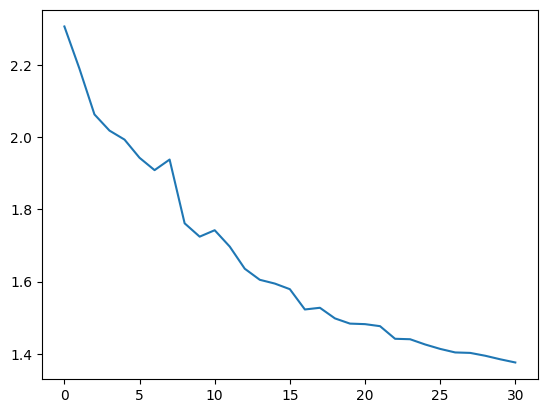

In [21]:
plt.plot([v for _, v in history.losses_centralized])

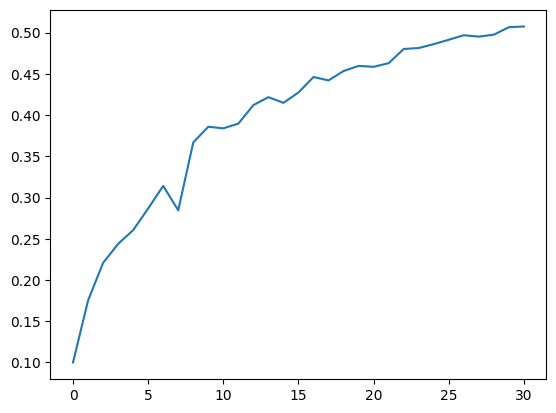

In [22]:
plt.plot([v for _, v in history.metrics_centralized["accuracy"]])